In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pywt
import numpy as np

from wvt_basis_manager_3d import WaveletBasisManager3d

NameError: name 'energies' is not defined

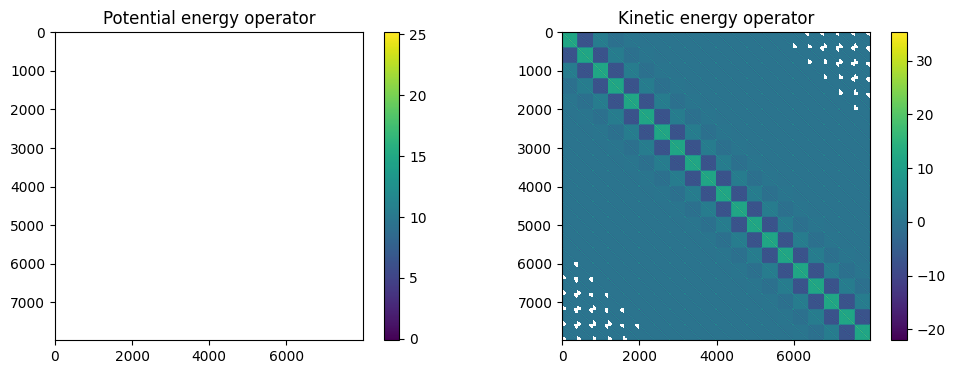

In [129]:
results = {}

def experiment(
    wvt_name="sym8",
    lims_x=(-7, 7),
    lims_y=(-7, 7),
    lims_z=(-7, 7),
    nsteps_x=10,
    nsteps_y=10,
    nsteps_z=10,
    do_plots=True,
    # plot_levels=10,
):
    wvt = pywt.Wavelet(wvt_name)
    wvt_man = WaveletBasisManager3d(
        wvt,
        (nsteps_x, nsteps_y, nsteps_z),
        lims_x,
        lims_y,
        lims_z,
    )
    potential_func = lambda xx, yy, zz: (xx**2 + yy**2 + zz**2) / 2
    total_steps = nsteps_x * nsteps_y * nsteps_z
    V_mat = wvt_man.get_matrix_elements(potential_func).reshape(total_steps, total_steps)
    T_mat = wvt_man.get_ke_matrix().reshape(total_steps, total_steps)

    if do_plots:
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(np.ma.masked_array(V_mat, V_mat == 0))
        plt.colorbar()
        plt.title("Potential energy operator")
        plt.subplot(1, 2, 2)
        plt.imshow(np.ma.masked_array(T_mat, T_mat == 0))
        plt.colorbar()
        plt.title("Kinetic energy operator")

    # H_mat = V_mat + T_mat
    # energies, states = np.linalg.eigh(H_mat)
    # eigh_error = np.abs(H_mat @ states - states * energies[None, :]).max()
    # if eigh_error > 1e-8:
    #     print("Warning: eigh error =", eigh_error)

    # if do_plots:
    #     plt.figure(figsize=(12, 4))
    #     plt.subplot(1, 2, 1)
    #     plt.stem(energies)
    #     plt.xlabel("level #")
    #     plt.ylabel("energy")

    #     plt.subplot(1, 2, 2)
    #     for n in range(plot_levels):
    #         result_func = wvt_man.reconstruct(states[:, n]) + energies[n]
    #         line, = result_func.plot();
    #         plt.plot([result_func.xx[0], result_func.xx[-1]], [energies[n], energies[n]], "--", color=line.get_color())
    #     plt.ylim(bottom=0);

    results["V"] = V_mat
    results["T"] = T_mat
    results['man'] = wvt_man
    # results["energies"], results["states"] = energies, states

    return energies

experiment(nsteps_x=20, nsteps_y=19, nsteps_z=21)

In [130]:
import tensorflow as tf

matrix = tf.convert_to_tensor(results["T"] + results["V"])
print(matrix.shape)

(7980, 7980)


  0%|          | 0/1000 [00:00<?, ?it/s]

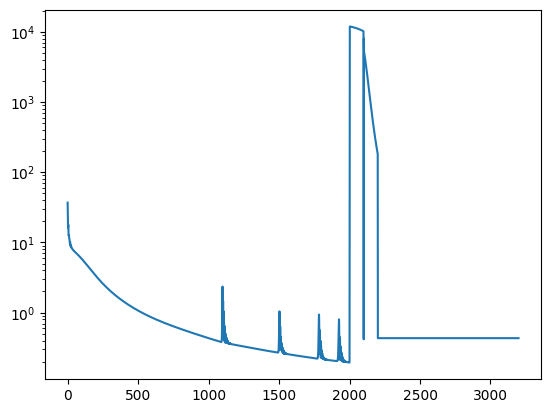

In [148]:
from tqdm.auto import trange

# solution = tf.Variable(tf.random.normal([7980], dtype="float64"))
# solution = tf.Variable(best_solution)
opt = tf.optimizers.SGD(0.1)

# hist = []
for i in trange(1000):
    # if opt.lr.value() < 1.0:
    #     opt.lr.assign(opt.lr * 1.05)
    with tf.GradientTape() as t:
        loss = (solution[None, :] @ matrix @ solution[:, None] / tf.reduce_sum(solution * solution))[0, 0]
        hist.append(loss.numpy())
    grads = t.gradient(loss, solution)
    opt.apply_gradients(zip([grads], [solution]))
    solution.assign(best_solution / tf.linalg.norm(best_solution))

plt.plot(hist)
plt.yscale("log");

In [152]:
np.abs(grads.numpy()).max()

0.1905553106167066

In [149]:
tf.norm(solution)

<tf.Tensor: shape=(), dtype=float64, numpy=1.0>

In [144]:
solution.assign(best_solution / tf.linalg.norm(best_solution))

<tf.Variable 'UnreadVariable' shape=(7980,) dtype=float64, numpy=
array([-1.38359281e-05, -1.43025217e-05, -1.65383865e-05, ...,
       -1.29667770e-05, -1.15431149e-05, -9.65410506e-06])>

In [135]:
loss

<tf.Tensor: shape=(), dtype=float64, numpy=0.1949817790220814>

In [132]:
best_solution = solution.numpy()

In [96]:
grads

<tf.Tensor: shape=(7980,), dtype=float64, numpy=
array([ 0.00079418,  0.00699352, -0.00369298, ..., -0.00065985,
       -0.0190512 ,  0.0016134 ])>